# 라이브러리 불러오기

In [1]:
#시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user

#전처리
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 피처엔지니어링 및 모델
import shap
from xgboost import XGBClassifier, XGBRegressor

# 마이데이터 더미데이터 생성

##### 예를 보여주기 위한 더미데이터 생성 

마이데이터와 투자 문항 결과를 확보할 수 없기 때문에 더미데이터 생성 </br>
예시를 보여주기 위해 랜덤으로 생성한 것이므로 성능 고려 X 

In [3]:
my_df=pd.read_csv('./data/MY_data.csv')

my_df.head()


,신한문항_투자목적,신한문항_투자위험감수,신한문항_투자기간,신한문항_고객수입원,신한문항_고객금융지식,마이데이터_고객ID,마이데이터_성별,마이데이터_연령,마이데이터_소득_선불카드자산,마이데이터_소득_월소득,마이데이터_소득_대출여부,마이데이터_투자경험_투자상품여부
0,2,4,5,1,2,c3e74278-0094-44ec-8145-86e3d5f276f7,Male,25,$235664.36,$3775.69,0,0
1,4,3,3,2,4,626ad386-4fa8-42a3-8bfe-3ae5556f7bc5,Female,71,$414872.17,$1208.03,0,0
2,2,4,3,3,3,b7ceeaed-bfec-4cf3-9152-94b93865dc70,Female,78,$39109.32,$9280.75,1,0
3,3,2,4,2,3,c48dc9b4-1165-47ee-9216-4ceb7948b10a,Female,55,$157248.23,$9190.86,0,1
4,1,3,4,3,4,07159849-fe51-49c2-938f-6ae7d6df549d,Male,74,$220020.00,$3752.19,0,0


In [5]:
def random_money_one(mi,mx,sp):
    import random
    price= random.randrange(mi, mx, sp)
    return price


def random_money(cnt,mi,mx,sp):
    import random
    price_list=[]
    for i in range(cnt):
        price= random.randrange(mi, mx, sp)
        price_list.append(price)
    return price_list

#랜덤 선불카드자산 생성
card_sum=random_money(1000,1000000,500000000,1000000)
my_df['마이데이터_소득_선불카드자산']=card_sum

#랜덤 월소득 생성 (보유 금액 대비 월소득 생성)
price_list=[]
for i in range(1000):
    mx_money=my_df['마이데이터_소득_선불카드자산'][i]
    price=random.randrange(0,mx_money//3,500000)
    price_list.append(price)
my_df['마이데이터_소득_월소득']=price_list

#대출 금액
my_df['마이데이터_소득_대출금액']=my_df.마이데이터_소득_대출여부.apply(lambda x : random_money_one(1000000,50000000,1000000)if x == 1 else 0)

# (난수생성) 마이데이터_소득_대출상품수
my_df['마이데이터_소득_대출상품수']=my_df.마이데이터_소득_대출여부.apply(lambda x : random_money_one(1,15,1)if x == 1 else 0)

# 투자상품금액
my_df['마이데이터_투자경험_투자상품금액']=my_df.마이데이터_투자경험_투자상품여부.apply(lambda x : random_money_one(1000000,50000000,1000000)if x == 1 else 0)

# (난수생성) 마이데이터_투자상품수
my_df['마이데이터_투자경험_투자상품수']=my_df.마이데이터_투자경험_투자상품여부.apply(lambda x : random_money_one(1,15,1)if x == 1 else 0)


#파생변수는 추후 생성 예정
#(파생변수)마이데이터_소득_총자산대비대출비율
my_df['마이데이터_파생변수_소득_총자산대비대출비율']=my_df['마이데이터_투자경험_투자상품금액']/my_df['마이데이터_소득_선불카드자산']

#(파생변수)월 소득 대비 월 지출비율

#(파생변수)최빈 투자상품종류

In [6]:
my_df

,신한문항_투자목적,신한문항_투자위험감수,신한문항_투자기간,신한문항_고객수입원,신한문항_고객금융지식,마이데이터_고객ID,마이데이터_성별,마이데이터_연령,마이데이터_소득_선불카드자산,마이데이터_소득_월소득,마이데이터_소득_대출여부,마이데이터_투자경험_투자상품여부,마이데이터_소득_대출금액,마이데이터_소득_대출상품수,마이데이터_투자경험_투자상품금액,마이데이터_투자경험_투자상품수,마이데이터_파생변수_소득_총자산대비대출비율
0,2,4,5,1,2,c3e74278-0094-44ec-8145-86e3d5f276f7,Male,25,428000000,90000000,0,0,0,0,0,0,0.000000
1,4,3,3,2,4,626ad386-4fa8-42a3-8bfe-3ae5556f7bc5,Female,71,26000000,6500000,0,0,0,0,0,0,0.000000
2,2,4,3,3,3,b7ceeaed-bfec-4cf3-9152-94b93865dc70,Female,78,421000000,37000000,1,0,7000000,13,0,0,0.000000
3,3,2,4,2,3,c48dc9b4-1165-47ee-9216-4ceb7948b10a,Female,55,315000000,42000000,0,1,0,0,20000000,11,0.063492
4,1,3,4,3,4,07159849-fe51-49c2-938f-6ae7d6df549d,Male,74,149000000,44000000,0,0,0,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,5,2,1,2,251c5ed2-f12d-480d-bfbc-c7b76fadf45b,Male,54,199000000,38500000,1,1,20000000,5,28000000,12,0.140704
996,1,2,3,2,1,f8be5c5d-bcce-49a9-8505-dd904c820fdd,Female,69,455000000,15500000,0,1,0,0,47000000,11,0.103297
997,3,5,1,1,2,ebd6892e-b128-404f-8944-2b8e4443a028,Female,68,387000000,65000000,0,1,0,0,36000000,14,0.093023
998,2,4,2,3,4,ed537f06-82bb-4d1c-95e9-a9bb68a39929,Female,55,64000000,11500000,0,1,0,0,48000000,11,0.750000


In [7]:
my_df.head()

,신한문항_투자목적,신한문항_투자위험감수,신한문항_투자기간,신한문항_고객수입원,신한문항_고객금융지식,마이데이터_고객ID,마이데이터_성별,마이데이터_연령,마이데이터_소득_선불카드자산,마이데이터_소득_월소득,마이데이터_소득_대출여부,마이데이터_투자경험_투자상품여부,마이데이터_소득_대출금액,마이데이터_소득_대출상품수,마이데이터_투자경험_투자상품금액,마이데이터_투자경험_투자상품수,마이데이터_파생변수_소득_총자산대비대출비율
0,2,4,5,1,2,c3e74278-0094-44ec-8145-86e3d5f276f7,Male,25,428000000,90000000,0,0,0,0,0,0,0.000000
1,4,3,3,2,4,626ad386-4fa8-42a3-8bfe-3ae5556f7bc5,Female,71,26000000,6500000,0,0,0,0,0,0,0.000000
2,2,4,3,3,3,b7ceeaed-bfec-4cf3-9152-94b93865dc70,Female,78,421000000,37000000,1,0,7000000,13,0,0,0.000000
3,3,2,4,2,3,c48dc9b4-1165-47ee-9216-4ceb7948b10a,Female,55,315000000,42000000,0,1,0,0,20000000,11,0.063492
4,1,3,4,3,4,07159849-fe51-49c2-938f-6ae7d6df549d,Male,74,149000000,44000000,0,0,0,0,0,0,0.000000


In [9]:
#랜덤 라벨 생성 0: 공격 1: 적극 2:중립 3:추구 4:안전
from sklearn.preprocessing import LabelEncoder
label=random_money(1000,1,6,1)
my_df['투자성향']=label
L_encoder = LabelEncoder()
L_encoder.fit(my_df["투자성향"])
my_df['투자성향']=L_encoder.transform(my_df["투자성향"])

from sklearn.preprocessing import LabelEncoder

train_data = my_df.drop(['마이데이터_고객ID'],axis=1)

L_encoder = LabelEncoder()
L_encoder.fit(train_data["마이데이터_성별"])
train_data['마이데이터_성별']=L_encoder.transform(train_data["마이데이터_성별"])

train_label=train_data['투자성향']

train_data.drop(['투자성향'],axis=1,inplace=True)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2, random_state=777)
print(len(X_train))
print(len(X_test))

train_data.head()

800
200


,신한문항_투자목적,신한문항_투자위험감수,신한문항_투자기간,신한문항_고객수입원,신한문항_고객금융지식,마이데이터_성별,마이데이터_연령,마이데이터_소득_선불카드자산,마이데이터_소득_월소득,마이데이터_소득_대출여부,마이데이터_투자경험_투자상품여부,마이데이터_소득_대출금액,마이데이터_소득_대출상품수,마이데이터_투자경험_투자상품금액,마이데이터_투자경험_투자상품수,마이데이터_파생변수_소득_총자산대비대출비율
0,2,4,5,1,2,1,25,428000000,90000000,0,0,0,0,0,0,0.000000
1,4,3,3,2,4,0,71,26000000,6500000,0,0,0,0,0,0,0.000000
2,2,4,3,3,3,0,78,421000000,37000000,1,0,7000000,13,0,0,0.000000
3,3,2,4,2,3,0,55,315000000,42000000,0,1,0,0,20000000,11,0.063492
4,1,3,4,3,4,1,74,149000000,44000000,0,0,0,0,0,0,0.000000


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


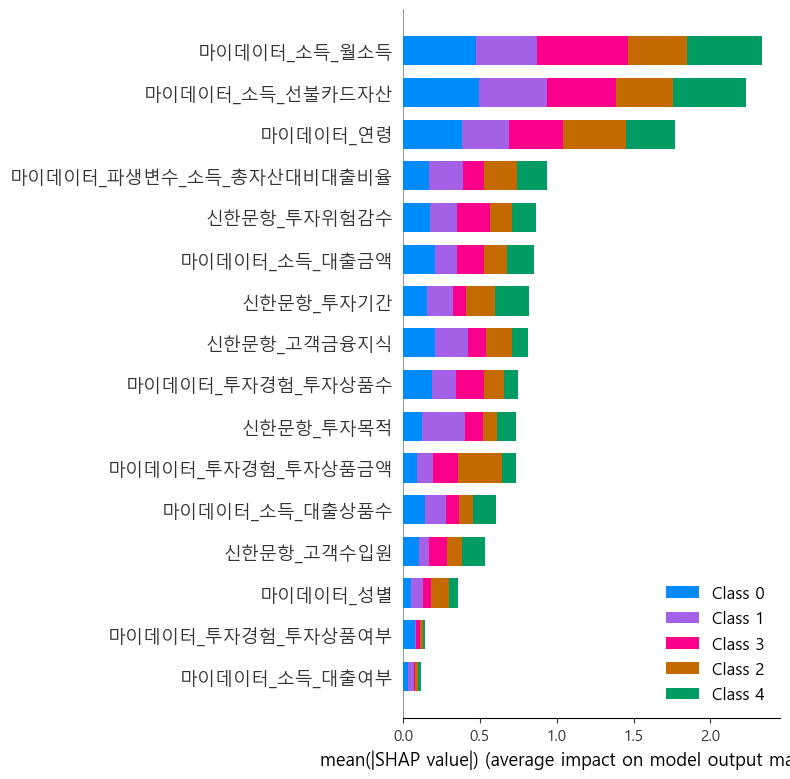

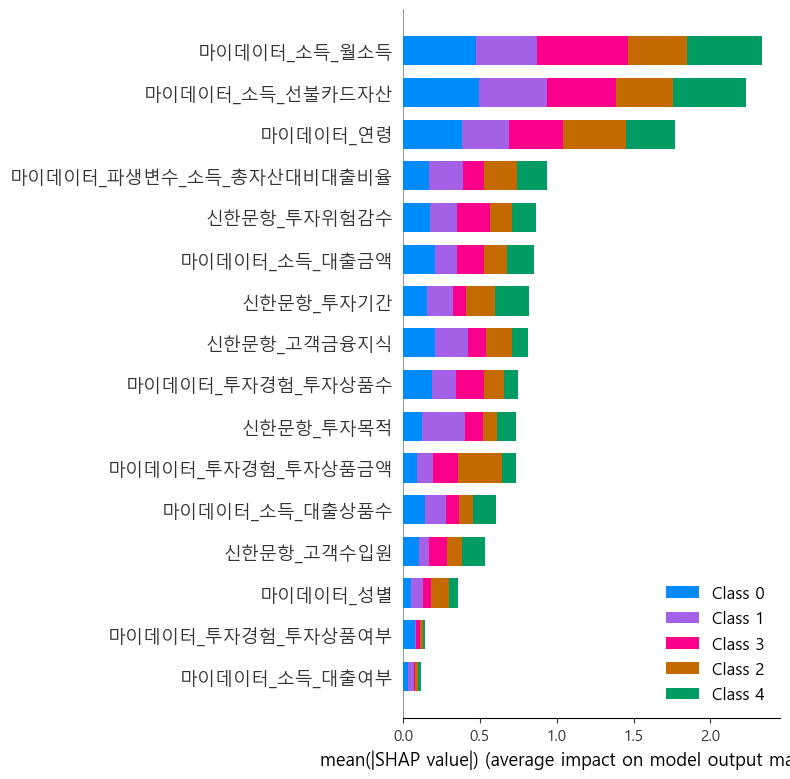

In [11]:
#SHAP로 피쳐임포턴스 확인
import shap
from xgboost import XGBClassifier, XGBRegressor

X_importance = train_data

model = XGBClassifier(random_state=0).fit(train_data, train_label)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)


#model = LGBMRegressor(random_state=0).fit(X_train_scaled, y)
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_importance)

# Plot summary_plot
shap.summary_plot(shap_values, X_importance)
# Plot summary_plot as barplot
shap.summary_plot(shap_values, X_importance, plot_type='bar')

# shap_sum = np.abs(shap_values).mean(axis=0)
# importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
# importance_df.columns = ['column_name', 'shap_importance']
# importance_df = importance_df.sort_values('shap_importance', ascending=False)
# importance_df

# 모델링
더미 데이터 생성 모델이므로 성능 X 예시

In [13]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

cb = CatBoostClassifier(random_state=2023)
cb.fit(X_train, y_train)
cb_predictions = cb.predict(X_test)
#accuracy_score(y_test, forest_predictions)forest_predictions = rf.predict(X_test)
accuracy_score(y_test, cb_predictions)

Learning rate set to 0.078231
0:	learn: 1.6000565	total: 131ms	remaining: 2m 10s
1:	learn: 1.5918443	total: 134ms	remaining: 1m 7s
2:	learn: 1.5826278	total: 138ms	remaining: 45.8s
3:	learn: 1.5759855	total: 142ms	remaining: 35.2s
4:	learn: 1.5684800	total: 145ms	remaining: 28.9s
5:	learn: 1.5594802	total: 149ms	remaining: 24.6s
6:	learn: 1.5535695	total: 152ms	remaining: 21.5s
7:	learn: 1.5462848	total: 155ms	remaining: 19.3s
8:	learn: 1.5357716	total: 159ms	remaining: 17.5s
9:	learn: 1.5276590	total: 162ms	remaining: 16s
10:	learn: 1.5189640	total: 166ms	remaining: 14.9s
11:	learn: 1.5111400	total: 169ms	remaining: 13.9s
12:	learn: 1.5037711	total: 173ms	remaining: 13.1s
13:	learn: 1.4975137	total: 176ms	remaining: 12.4s
14:	learn: 1.4904633	total: 179ms	remaining: 11.8s
15:	learn: 1.4801782	total: 183ms	remaining: 11.3s
16:	learn: 1.4720510	total: 186ms	remaining: 10.8s
17:	learn: 1.4666209	total: 190ms	remaining: 10.3s
18:	learn: 1.4607206	total: 193ms	remaining: 9.96s
19:	learn: 1

165:	learn: 0.8602976	total: 796ms	remaining: 4s
166:	learn: 0.8564802	total: 801ms	remaining: 3.99s
167:	learn: 0.8549588	total: 804ms	remaining: 3.98s
168:	learn: 0.8516720	total: 808ms	remaining: 3.97s
169:	learn: 0.8493824	total: 812ms	remaining: 3.97s
170:	learn: 0.8459690	total: 816ms	remaining: 3.96s
171:	learn: 0.8430135	total: 820ms	remaining: 3.95s
172:	learn: 0.8407583	total: 824ms	remaining: 3.94s
173:	learn: 0.8385638	total: 827ms	remaining: 3.93s
174:	learn: 0.8358398	total: 831ms	remaining: 3.92s
175:	learn: 0.8328263	total: 834ms	remaining: 3.9s
176:	learn: 0.8304636	total: 838ms	remaining: 3.9s
177:	learn: 0.8269294	total: 841ms	remaining: 3.88s
178:	learn: 0.8250371	total: 845ms	remaining: 3.87s
179:	learn: 0.8218226	total: 848ms	remaining: 3.86s
180:	learn: 0.8192194	total: 852ms	remaining: 3.85s
181:	learn: 0.8172597	total: 855ms	remaining: 3.84s
182:	learn: 0.8143930	total: 858ms	remaining: 3.83s
183:	learn: 0.8112115	total: 861ms	remaining: 3.82s
184:	learn: 0.809

326:	learn: 0.5264113	total: 1.39s	remaining: 2.86s
327:	learn: 0.5242840	total: 1.39s	remaining: 2.85s
328:	learn: 0.5232595	total: 1.4s	remaining: 2.85s
329:	learn: 0.5214707	total: 1.4s	remaining: 2.84s
330:	learn: 0.5205777	total: 1.4s	remaining: 2.84s
331:	learn: 0.5193261	total: 1.41s	remaining: 2.83s
332:	learn: 0.5184996	total: 1.41s	remaining: 2.82s
333:	learn: 0.5166034	total: 1.41s	remaining: 2.82s
334:	learn: 0.5155677	total: 1.42s	remaining: 2.81s
335:	learn: 0.5136590	total: 1.42s	remaining: 2.81s
336:	learn: 0.5119222	total: 1.42s	remaining: 2.8s
337:	learn: 0.5100665	total: 1.43s	remaining: 2.79s
338:	learn: 0.5086745	total: 1.43s	remaining: 2.79s
339:	learn: 0.5079357	total: 1.43s	remaining: 2.78s
340:	learn: 0.5069608	total: 1.44s	remaining: 2.77s
341:	learn: 0.5053768	total: 1.44s	remaining: 2.77s
342:	learn: 0.5039029	total: 1.44s	remaining: 2.76s
343:	learn: 0.5032575	total: 1.45s	remaining: 2.76s
344:	learn: 0.5014658	total: 1.45s	remaining: 2.75s
345:	learn: 0.50

501:	learn: 0.3388956	total: 1.98s	remaining: 1.96s
502:	learn: 0.3381879	total: 1.98s	remaining: 1.96s
503:	learn: 0.3370978	total: 1.99s	remaining: 1.96s
504:	learn: 0.3365302	total: 1.99s	remaining: 1.95s
505:	learn: 0.3356735	total: 1.99s	remaining: 1.95s
506:	learn: 0.3349522	total: 2s	remaining: 1.94s
507:	learn: 0.3341081	total: 2s	remaining: 1.94s
508:	learn: 0.3328937	total: 2s	remaining: 1.93s
509:	learn: 0.3317340	total: 2.01s	remaining: 1.93s
510:	learn: 0.3310298	total: 2.01s	remaining: 1.92s
511:	learn: 0.3305529	total: 2.01s	remaining: 1.92s
512:	learn: 0.3301638	total: 2.02s	remaining: 1.91s
513:	learn: 0.3293904	total: 2.02s	remaining: 1.91s
514:	learn: 0.3290238	total: 2.02s	remaining: 1.9s
515:	learn: 0.3282326	total: 2.02s	remaining: 1.9s
516:	learn: 0.3276661	total: 2.03s	remaining: 1.9s
517:	learn: 0.3267917	total: 2.03s	remaining: 1.89s
518:	learn: 0.3262092	total: 2.04s	remaining: 1.89s
519:	learn: 0.3254356	total: 2.04s	remaining: 1.88s
520:	learn: 0.3249816	to

669:	learn: 0.2424948	total: 2.57s	remaining: 1.26s
670:	learn: 0.2419610	total: 2.57s	remaining: 1.26s
671:	learn: 0.2413137	total: 2.58s	remaining: 1.26s
672:	learn: 0.2408259	total: 2.58s	remaining: 1.25s
673:	learn: 0.2405349	total: 2.59s	remaining: 1.25s
674:	learn: 0.2401275	total: 2.59s	remaining: 1.25s
675:	learn: 0.2397130	total: 2.59s	remaining: 1.24s
676:	learn: 0.2393518	total: 2.6s	remaining: 1.24s
677:	learn: 0.2390498	total: 2.6s	remaining: 1.24s
678:	learn: 0.2385493	total: 2.61s	remaining: 1.23s
679:	learn: 0.2383211	total: 2.61s	remaining: 1.23s
680:	learn: 0.2378513	total: 2.61s	remaining: 1.22s
681:	learn: 0.2373080	total: 2.62s	remaining: 1.22s
682:	learn: 0.2369455	total: 2.62s	remaining: 1.22s
683:	learn: 0.2365461	total: 2.63s	remaining: 1.21s
684:	learn: 0.2364076	total: 2.63s	remaining: 1.21s
685:	learn: 0.2361594	total: 2.63s	remaining: 1.21s
686:	learn: 0.2360221	total: 2.64s	remaining: 1.2s
687:	learn: 0.2354835	total: 2.64s	remaining: 1.2s
688:	learn: 0.23

831:	learn: 0.1817383	total: 3.16s	remaining: 639ms
832:	learn: 0.1814244	total: 3.17s	remaining: 635ms
833:	learn: 0.1811628	total: 3.17s	remaining: 631ms
834:	learn: 0.1808346	total: 3.17s	remaining: 627ms
835:	learn: 0.1805143	total: 3.18s	remaining: 623ms
836:	learn: 0.1802654	total: 3.18s	remaining: 620ms
837:	learn: 0.1800422	total: 3.19s	remaining: 616ms
838:	learn: 0.1797796	total: 3.19s	remaining: 612ms
839:	learn: 0.1793762	total: 3.19s	remaining: 608ms
840:	learn: 0.1790047	total: 3.19s	remaining: 604ms
841:	learn: 0.1785991	total: 3.2s	remaining: 600ms
842:	learn: 0.1783848	total: 3.2s	remaining: 596ms
843:	learn: 0.1780514	total: 3.21s	remaining: 593ms
844:	learn: 0.1777318	total: 3.21s	remaining: 589ms
845:	learn: 0.1775703	total: 3.21s	remaining: 585ms
846:	learn: 0.1772809	total: 3.22s	remaining: 581ms
847:	learn: 0.1769728	total: 3.22s	remaining: 577ms
848:	learn: 0.1766308	total: 3.22s	remaining: 573ms
849:	learn: 0.1761953	total: 3.23s	remaining: 569ms
850:	learn: 0.

0.2

# 랜덤 테스트데이터 생성

In [15]:
test_data=pd.read_csv('./data/test_data.csv')



def random_money_one(mi,mx,sp):
    import random
    price= random.randrange(mi, mx, sp)
    return price


def random_money(cnt,mi,mx,sp):
    import random
    price_list=[]
    for i in range(cnt):
        price= random.randrange(mi, mx, sp)
        price_list.append(price)
    return price_list

#랜덤 선불카드자산 생성
card_sum=random_money(1000,1000000,500000000,1000000)
test_data['마이데이터_소득_선불카드자산']=card_sum

#랜덤 월소득 생성 (보유 금액 대비 월소득 생성)
price_list=[]
for i in range(1000):
    mx_money=my_df['마이데이터_소득_선불카드자산'][i]
    price=random.randrange(0,mx_money//3,500000)
    price_list.append(price)
test_data['마이데이터_소득_월소득']=price_list

#대출 금액
test_data['마이데이터_소득_대출금액']=test_data.마이데이터_소득_대출여부.apply(lambda x : random_money_one(1000000,50000000,1000000)if x == 1 else 0)

# (난수생성) 마이데이터_소득_대출상품수
test_data['마이데이터_소득_대출상품수']=test_data.마이데이터_소득_대출여부.apply(lambda x : random_money_one(1,15,1)if x == 1 else 0)

# 투자상품금액
test_data['마이데이터_투자경험_투자상품금액']=test_data.마이데이터_투자경험_투자상품여부.apply(lambda x : random_money_one(1000000,50000000,1000000)if x == 1 else 0)

# (난수생성) 마이데이터_투자상품수
test_data['마이데이터_투자경험_투자상품수']=test_data.마이데이터_투자경험_투자상품여부.apply(lambda x : random_money_one(1,15,1)if x == 1 else 0)


#파생변수는 추후 생성 예정
#(파생변수)마이데이터_소득_총자산대비대출비율
test_data['마이데이터_파생변수_소득_총자산대비대출비율']=test_data['마이데이터_투자경험_투자상품금액']/test_data['마이데이터_소득_선불카드자산']

from sklearn.preprocessing import LabelEncoder

test_data = test_data.drop(['마이데이터_고객ID'],axis=1)

test_data['마이데이터_성별']=L_encoder.transform(test_data["마이데이터_성별"])



test_data.head()

,신한문항_투자목적,신한문항_투자위험감수,신한문항_투자기간,신한문항_고객수입원,신한문항_고객금융지식,마이데이터_성별,마이데이터_연령,마이데이터_소득_선불카드자산,마이데이터_소득_월소득,마이데이터_소득_대출여부,마이데이터_투자경험_투자상품여부,마이데이터_소득_대출금액,마이데이터_소득_대출상품수,마이데이터_투자경험_투자상품금액,마이데이터_투자경험_투자상품수,마이데이터_파생변수_소득_총자산대비대출비율
0,4,1,2,3,1,0,73,42000000,137000000,1,0,46000000,4,0,0,0.000000
1,4,5,1,2,4,0,50,319000000,3000000,0,1,0,0,27000000,7,0.084639
2,2,2,4,1,3,1,89,30000000,131500000,1,1,14000000,7,25000000,9,0.833333
3,4,5,4,1,2,0,88,388000000,90500000,1,0,17000000,11,0,0,0.000000
4,1,4,1,2,2,1,26,367000000,32500000,0,0,0,0,0,0,0.000000


In [16]:
predict_data=cb.predict(test_data)

predict_label=predict_data.reshape(-1,)

test_data['예측라벨']=predict_label

def decode_label(x):
    if x == 0 :
        return '공격투자형'
    if x == 1: 
        return '적극투자형'
    if x == 2:
        return '중립투자형'
    if x == 3:
        return '추구투자형'
    else :
        return '안전투자형'

test_data['예측라벨']=test_data.예측라벨.apply(decode_label)

for i in range(10):
    print('{}번째 고객의 성향은 {} 입니다.'.format(i,test_data['예측라벨'][i]))

0번째 고객의 성향은 중립투자형 입니다.
1번째 고객의 성향은 중립투자형 입니다.
2번째 고객의 성향은 중립투자형 입니다.
3번째 고객의 성향은 안전투자형 입니다.
4번째 고객의 성향은 안전투자형 입니다.
5번째 고객의 성향은 중립투자형 입니다.
6번째 고객의 성향은 안전투자형 입니다.
7번째 고객의 성향은 중립투자형 입니다.
8번째 고객의 성향은 중립투자형 입니다.
9번째 고객의 성향은 중립투자형 입니다.


In [1]:
import numpy as np
import pandas as pd
import json
from tqdm import tqdm
from pandas.tseries.offsets import BDay
from bs4 import BeautifulSoup
import requests
from urllib.request import Request, urlopen
from user_agent import generate_user_agent
import gzip, pickle
import time
from get_price_etf import Get_price_etf
hdr = {'User-Agent': generate_user_agent(os='win', device_type='desktop')}

# 1. 예금, 적금, ETF, 펀드 데이터 가져오기
1. 예금, 적금 데이터 : 금융감독원 - 금융상품 통합 비교공시 데이터 오픈 API
2. ETF 데이터 : 네이버 금융 크롤링
3. 펀드 데이터 : 펀드 슈퍼마켓 크롤링

In [2]:
# 1. 예금, 적금 데이터 API로 가져오기
def get_info_bank(name_):
    def get_product_deposit(KEY, FINGROUP, PAGE, COMPANY):
        url = "http://finlife.fss.or.kr/finlifeapi/depositProductsSearch.xml?auth={}&topFinGrpNo={}&pageNo={}&financeCd={}".format(
            KEY, FINGROUP, PAGE, COMPANY)
        response = requests.get(url, headers=hdr).content.decode('euc-kr')
        # html을 파싱할 때는 html.parser를,
        # xml을 파싱할 때는 lxml-xml을 사용
        xml_obj = BeautifulSoup(response, 'html.parser')
        rows = xml_obj.findAll("product")
        return rows
    def get_product_saving(KEY, FINGROUP, PAGE, COMPANY):
        url = "http://finlife.fss.or.kr/finlifeapi/savingProductsSearch.xml?auth={}&topFinGrpNo={}&pageNo={}&financeCd={}".format(
            KEY, FINGROUP, PAGE, COMPANY)
        response = requests.get(url).content.decode('euc-kr')
        # html을 파싱할 때는 html.parser를,
        # xml을 파싱할 때는 lxml-xml을 사용
        xml_obj = BeautifulSoup(response, 'html.parser')
        rows = xml_obj.findAll("product")
        return rows
    # 1) parameter 설정
    KEY = "MY_DATA_KEY"
    # 금융기관별 코드 list
    fin_grp_list = [
        '020000'  # 은행
        , '030200'  # 여신전문
        , '030300'  # 저축은행
        # , '050000' # 보험회사
        # , '060000' # 금융투자
    ]
    # target
    company_list = '신한'
    bank_list = list()
    if name_ == 'deposit':
        item_list = [
            'dcls_month'  # 공시제출월
            , 'kor_co_nm'  # 금융회사명
            , 'fin_prdt_nm'  # 금융상품명
            , 'join_way'  # 가입방법
            , 'mtrt_int'  # 만기 후 이자율
            , 'spcl_cnd'  # 우대조건
            , 'join_deny'  # 가입제한 1:제한X, 2:서민전용, 3:일부제한
            , 'join_member'  # 가입대상
            , 'max_limit'  # 최고한도
            , 'intr_rate_type_nm'  # 저축 금리 유형명
            , 'rsrv_type_nm'  # 적립유형명
            , 'save_tm'  # 저축 기간
            , 'intr_rate'  # 저축금
            , 'intr_rate2'  # 최고 우대금리
        ]
        # 금융기관별로 상품 정보를 호출한 후 의도한 스펙을 스크래핑하는 for-loop 구문
        for PAGE in tqdm(range(0,100,1)):
            for grp in fin_grp_list:
                products = get_product_deposit(KEY, grp, PAGE, company_list)

                for p in range(0, len(products)):
                    savings_product_list = list()
                    for i in item_list:
                        try:
                            savings_info = products[p].find(i).text # 특정 스펙을 수집하는 중에 어떤 종류든 error 발생시
                        except:
                            savings_info = "" # 해당 값은 ""로 대체

                        savings_product_list.append(savings_info)
                    bank_list.append(savings_product_list)
                time.sleep(1)
    elif name_ == 'saving':
        item_list = [
            'dcls_month'  # 공시제출월
            , 'kor_co_nm'  # 금융회사명
            , 'fin_prdt_nm'  # 금융상품명
            , 'join_way'  # 가입방법
            , 'mtrt_int'  # 만기 후 이자율
            , 'spcl_cnd'  # 우대조건
            , 'join_deny'  # 가입제한 1:제한X, 2:서민전용, 3:일부제한
            , 'join_member'  # 가입대상
            , 'max_limit'  # 최고한도
            , 'intr_rate_type_nm'  # 저축 금리 유형명
            , 'rsrv_type_nm'  # 적립유형명
            , 'save_tm'  # 저축 기간
            , 'intr_rate'  # 저축금
            , 'intr_rate2'  # 최고 우대금리
        ]
        for PAGE in tqdm(range(0,100,1)):
            for grp in fin_grp_list:
                products = get_product_saving(KEY, grp, PAGE, company_list)

                for p in range(0, len(products)):
                    savings_product_list = list()
                    for i in item_list:
                        try:
                            savings_info = products[p].find(i).text # 특정 스펙을 수집하는 중에 어떤 종류든 error 발생시
                        except:
                            savings_info = "" # 해당 값은 ""로 대체

                        savings_product_list.append(savings_info)
                    bank_list.append(savings_product_list)
                time.sleep(1)
    return bank_list
# 2. 예금, 적금 df 만들기
def get_price_deposit():
    bank_deposit_list = get_info_bank(name_='deposit')
    bank_deposit_df = pd.DataFrame(bank_deposit_list, columns=[
        '공시제출월'
        , '금융회사명'
        , '금융상품명'
        , '가입방법'
        , '만기후이자율'
        , '우대조건'
        , '가입제한'  # 1:제한X, 2:서민전용, 3:일부제한
        , '가입대상'
        , '최고한도'
        , '저축금리유형명'
        , '적립유형명'
        , '저축기간'
        , '저축금리'
        , '최고우대금리'
    ])
    start = time.time()
    with gzip.open('./raw_price_deposit', 'wb') as f:
        pickle.dump(bank_deposit_df, f)
        print(f'Saving Complete({round((time.time() - start) / 60, 2)}min): ./raw_price_deposit')
    return bank_deposit_df
def get_price_saving():
    bank_savings_list = get_info_bank(name_='saving')
    bank_savings_df = pd.DataFrame(bank_savings_list, columns=[
        '공시제출월'
        , '금융회사명'
        , '금융상품명'
        , '가입방법'
        , '만기후이자율'
        , '우대조건'
        , '가입제한'  # 1:제한X, 2:서민전용, 3:일부제한
        , '가입대상'
        , '최고한도'
        , '저축금리유형명'
        , '적립유형명'
        , '저축기간'
        , '저축금리'
        , '최고우대금리'
    ])
    start = time.time()
    with gzip.open('./raw_price_saving', 'wb') as f:
        pickle.dump(bank_savings_df, f)
        print(f'Saving Complete({round((time.time() - start) / 60, 2)}min): ./raw_price_saving')
    return bank_savings_df

In [ ]:
# 예금, 적금 데이터 가져오기
get_price_deposit()
get_price_saving()

In [3]:
# 2. ETF 데이터 크롤링하기
def get_info_etf():
    # 1) naver.finance에서 etf 정보 크롤링
    url = 'https://finance.naver.com/api/sise/etfItemList.nhn'
    raw_data = urlopen(url).read().decode('euc-kr')
    json_data = json.loads(raw_data)
    etf_list = list()
    for each in tqdm(json_data['result']['etfItemList']):
        url = 'https://finance.naver.com/item/main.nhn?code=' + each['itemcode']
        req = Request(url, headers=hdr)
        raw_data = urlopen(url).read().decode('euc-kr')
        soup = BeautifulSoup(raw_data)
        info1 = soup.body.find('table', summary="시가총액 정보").find_all('em')
        info2 = soup.body.find('table', summary="기초지수 정보").find_all('td')
        info3 = soup.body.find('table', summary="펀드보수 정보").find_all('td')
        info_all = [
            each['itemname'],
            each['itemcode'],
            info1[0].get_text(strip=True).replace('\t', '').replace('\n', '') + '억원',
            info1[1].get_text(),
            info2[0].get_text(),
            info2[1].get_text(),
            info2[2].get_text(),
            info3[0].get_text(),
            info3[1].get_text()
        ]
        etf_list.append(info_all)

    # 2) 위 과정의 결과물은 list이기 때문에 이것을 dataframe으로 변형
    # DF로 변형하면서 컬럼명을 국문으로 지정
    etf_df = pd.DataFrame(etf_list, columns=[
        'ETF명'
        , 'ETF코드'
        , '시가총액'
        , '상장주식수'
        , '기초지수'
        , '유형'
        , '상장일'
        , '펀드보수'
        , '운용사'
    ])
    # 3) 신한자산운용의 etf만 가져오기
    etf_df_shinhan = etf_df[etf_df['운용사'].str.contains('신한')]
    start = time.time()
    with gzip.open('./raw_data_etf_info', 'wb') as f:
        pickle.dump(etf_df_shinhan, f)
        print(f'Saving Complete({round((time.time() - start) / 60, 2)}min): ./raw_data_etf_info')
    return etf_df_shinhan

# 2. ETF price 가져오기
def get_price_etf(index_기준):
    df_etf_day = Get_price_etf(index_기준) # 개인 DB에서 가져온 ETF 가격 정보 pickle 형태로 저장
    return df_etf_day
# 3. etf data 가져오기
index_기준 = '2020-01-01'
get_price_etf(index_기준)
get_info_etf()

In [ ]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from time import sleep
import gzip, pickle
import time
import re
import math
import os

def Get_info_fund():
    keyword = "신한"
    executable_path = './chromedriver'
    url = "https://www.fosskorea.com/fmm/FMM1010301/main.do"

    class Search_Fund:
        '''

        fund_supermarket 크롤링 하는 클래스

        '''
        click_time = 1.5
        send_time = 0.5
        date_time = 2  # 날짜 변경해서 새로 driver를 켤 때 변경시간
        wait_time = 10  # 오류 발생시 기다리는 시간

        def __init__(self):
            '''
                기본 드라이브 실행
            '''
            # create a new chrome session
            prefs = {'profile.default_content_setting_values': {'cookies': 2,
                                                                'images': 2, 'plugins': 2, 'popups': 2,
                                                                'geolocation': 2,
                                                                'notifications': 2,
                                                                'auto_select_certificate': 2, 'fullscreen': 2,
                                                                'mouselock': 2, 'mixed_script': 2,
                                                                'media_stream': 2, 'media_stream_mic': 2,
                                                                'media_stream_camera': 2, 'protocol_handlers': 2,
                                                                'ppapi_broker': 2, 'automatic_downloads': 2,
                                                                'midi_sysex': 2, 'push_messaging': 2,
                                                                'ssl_cert_decisions': 2, 'metro_switch_to_desktop': 2,
                                                                'protected_media_identifier': 2,
                                                                'app_banner': 2, 'site_engagement': 2,
                                                                'durable_storage': 2}}
            options = Options()
            # options.add_experimental_option('prefs', prefs)
            # options.add_argument("start-maximized")
            # options.add_argument("disable-infobars")
            # options.add_argument("--disable-extensions")
            # options.add_argument('--headless')
            # options.add_argument('--no-sandbox')

            self.Crawling_funds = dict({"Fund": [],"Type": [], "Risk": [],"Rets_1개월": [],"Rets_3개월": [],"Rets_6개월": [],"Rets_1년": [],"Rets_2년": [],"Rets_3년": [],"Rets_5년": [],"Rets_설정후": [], "Std": []})

            try:
                self.driver = webdriver.Chrome(options=options, executable_path=executable_path);
                sleep(self.date_time)
            except:
                sleep(self.wait_time)
                self.driver = webdriver.Chrome(options=options, executable_path=executable_path);
                sleep(self.date_time)
            self.driver.implicitly_wait(self.wait_time)
            self.driver.maximize_window()

            try:
                self.driver.get(url);
                sleep(self.date_time)
            except:
                sleep(self.wait_time)
                self.driver.get(url);
                sleep(self.date_time)
        def Search_keyword(self, keyword):
            self.keyword = keyword
            # 키워드 입력
            try:
                self.driver.find_element(By.ID, 'fundName2').send_keys(keyword);
                sleep(self.send_time)
            except:
                sleep(self.wait_time)
                self.driver.find_element(By.ID, 'fundName2').send_keys(keyword);
                sleep(self.send_time)
            self.driver.find_element(By.CLASS_NAME, 'bt-img.search-bt').click();
            sleep(self.click_time)

            try:
                self.total_cnt = int(self.driver.find_element(By.ID, 'totalCnt').text)
            except:
                sleep(self.wait_time)
                self.total_cnt = int(self.driver.find_element(By.ID, 'totalCnt').text)
            self.total_page = math.ceil(self.total_cnt / 20)
            print("총 데이터 개수 : ", self.total_cnt)
            print("총 페이지 개수 : ", self.total_page)

        def pages(self):
            '''
                모든 페이지를 크롤링
            '''
            lastPage = 7
            # 현재 페이지
            isLastPage = False
            curPage = 1
            while (not isLastPage):
                ## 페이지 크롤링
                self.page_crawling_funds(curPage)
                if curPage == int(lastPage):
                    isLastPage = True
                else:
                    self.driver.find_element(By.XPATH,
                                             f'//*[@id="container"]/div[1]/div[1]/div[3]/div/span/a[{curPage + 1}]').click();
                    sleep(self.click_time)
                    curPage += 1

        def page_crawling_funds(self, curPage):
            if curPage != 7:
                range_end = 21
            else:
                range_end = 4
            for i in range(1, range_end):
                # 펀드 이름 가져오기
                try:
                    fund_name = self.driver.find_element(By.XPATH,
                                                         f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dt/a').text;
                    sleep(self.click_time)
                except:
                    sleep(self.click_time)
                    fund_name = self.driver.find_element(By.XPATH,
                                                         f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dt/a').text;
                    sleep(self.click_time)
                # 펀드 유형 가져오기
                try:
                    type_ = self.driver.find_element(By.XPATH,
                                                     f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dd[1]/table/tbody/tr[1]/td[1]').text;
                    sleep(self.click_time)
                except:
                    sleep(self.click_time)
                    type_ = self.driver.find_element(By.XPATH,
                                                     f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dd[1]/table/tbody/tr[1]/td[1]').text;
                    sleep(self.click_time)
                # 펀드 위험구분 가져오기
                try:
                    risk = self.driver.find_element(By.XPATH,
                                                    f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dd[2]/span[2]').text;
                    sleep(self.click_time)
                except:
                    sleep(self.click_time)
                    risk = self.driver.find_element(By.XPATH,
                                                    f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dd[2]/span[2]').text;
                    sleep(self.click_time)
                # 펀드 클릭
                try:
                    self.driver.find_element(By.XPATH,
                                             f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dt/a').click();
                    sleep(self.click_time)
                except:
                    self.driver.find_element(By.XPATH,
                                         f'//*[@id="fundList"]/div[3]/ul/li[{i}]/dl/dt/a').click();
                    sleep(self.click_time)
                try:
                    self.driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/div/div/ul/li[2]/a').click();
                    sleep(self.click_time)
                except:
                    sleep(self.click_time)
                    self.driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/div/div/ul/li[2]/a').click();
                    sleep(self.click_time)
                # 수익률 가져오기
                try:
                    rets_list1 = self.driver.find_element(By.XPATH, f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[1]/span').text,
                    rets_list2 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[2]/span').text,
                    rets_list3 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[3]/span').text,
                    rets_list4 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[4]/span').text,
                    rets_list5 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[5]/span').text,
                    rets_list6 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[6]/span').text,
                    rets_list7 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[7]/span').text,
                    rets_list8 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[8]/span').text;
                except:
                    sleep(self.click_time)
                    rets_list1 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[1]/span').text,
                    rets_list2 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[2]/span').text,
                    rets_list3 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[3]/span').text,
                    rets_list4 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[4]/span').text,
                    rets_list5 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[5]/span').text,
                    rets_list6 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[6]/span').text,
                    rets_list7 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[7]/span').text,
                    rets_list8 = self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[1]/div/div[3]/table/tbody/tr[1]/td[8]/span').text;
                # 위험도 가져오기
                try:
                    std = re.sub('표준편차 ','',self.driver.find_element(By.XPATH, f'//*[@id="tab_contents02"]/div[2]/div/div[2]/ul/li[1]/dl/dt').text);
                    std = float(std.replace('%',''))
                except:
                    sleep(self.click_time)
                    try:
                        std = re.sub('표준편차 ', '', self.driver.find_element(By.XPATH,f'//*[@id="tab_contents02"]/div[2]/div/div[2]/ul/li[1]/dl/dt').text);
                        std = float(std.replace('%',''))
                    except:
                        std = 0
                self.Crawling_funds["Fund"].append(fund_name)
                self.Crawling_funds["Type"].append(type_)
                self.Crawling_funds["Risk"].append(risk)
                self.Crawling_funds["Rets_1개월"].append(rets_list1)
                self.Crawling_funds["Rets_3개월"].append(rets_list2)
                self.Crawling_funds["Rets_6개월"].append(rets_list3)
                self.Crawling_funds["Rets_1년"].append(rets_list4)
                self.Crawling_funds["Rets_2년"].append(rets_list5)
                self.Crawling_funds["Rets_3년"].append(rets_list6)
                self.Crawling_funds["Rets_5년"].append(rets_list7)
                self.Crawling_funds["Rets_설정후"].append(rets_list8)
                self.Crawling_funds["Std"].append(std)
                # 끄기
                try:
                    self.driver.find_element(By.XPATH, '//*[@id="compare_btn"]/a[1]').click();
                    sleep(self.click_time)
                except:
                    sleep(self.wait_time)
                    self.driver.find_element(By.XPATH, '//*[@id="compare_btn"]/a[1]').click();
                    sleep(self.click_time)
        def display(self):
            '''
            기본 정보
            '''
            print("키워드 : ", self.keyword)
            print("총 페이지 수 : ", self.total_page, "총 데이터 수 : ", self.total_cnt)

        def Save(self):
            '''
            데이터 저장
            '''
            # pd.DataFrame(self.Crawling_funds).to_csv("./펀드슈퍼마켓/{}.csv".format(self.keyword), index=False,
            #                                         encoding='euc-kr')
            start = time.time()
            with gzip.open('./펀드슈퍼마켓/raw_info_fund', 'wb') as f:
                pickle.dump(pd.DataFrame(Search.Crawling_funds), f)
                print(f'Saving Complete({round((time.time() - start) / 60, 2)}min): ./펀드슈퍼마켓/raw_info_fund')
    if not os.path.exists("./펀드슈퍼마켓"):
        os.makedirs("./펀드슈퍼마켓")
    try:
        Search = Search_Fund()
        Search.Search_keyword(keyword)
        try:
            Search.pages()
        except:
            try:
                print("오류... 다시 시도 중...")
                sleep(Search.wait_time)
                Search.wait_time = 30
                Search.pages()
            except:
                print("오류... 다시 시도 중...")
                sleep(Search.wait_time)
                Search.wait_time = 60
                Search.pages()
        Search.Save()
        Search.display()
        Search.driver.close()
        sleep(Search.date_time)
        print("fund 정보 불러오기 완료")
    except:
        print("오류 발생 종료 ")
        del Search
# 4. Fund data 가져오기
Get_info_fund() # 펀드 슈퍼마켓에서 크롤링 한 정보 pickle 형태로 저장

# 2. ETF,펀드 성과 분석

In [4]:
class PortfolioAnalysis:
    def __init__(self, daily_return):
        # 포트폴리오 일별 수익률
        self.daily_return = daily_return
        # 포트폴리오 복리수익률
        self.cum_ret_cmpd = self.daily_return.add(1).cumprod()
        # 포트폴리오 단리수익률
        self.cum_ret_smpl = self.daily_return.cumsum()
        # 분석 기간
        self.num_years = self.get_num_year(self.daily_return.index.year.unique())
        self.drawdown = self._calculate_dd(self.cum_ret_cmpd)
        self.mdd = self._calculate_mdd(self.drawdown)
        self.cagr = self._calculate_cagr(self.cum_ret_cmpd, self.num_years)
        self.std = self._calculate_std(self.daily_return, self.num_years)
        self.sharpe = self.cagr / self.std

    def get_num_year(self, num_years):
        num_years = len(num_years)
        if num_years ==2 :
            # 기간이 1년 이상이면, 1년이란 길이의 기준은 데이터의 갯수로 한다.
            start_date = self.daily_return.index[0]
            end_date = start_date + pd.DateOffset(years=1)
            date_list = self.daily_return.loc[start_date:end_date].index
            num_days = len(date_list)
        elif num_years==1:
            # 기간이 1년 미만이면, 1년이란 길이의 기준은 다음해까지의 영업일 기준으로 가상으로 확장시킨다.
            start_date = self.daily_return.index[0]
            end_date = self.daily_return.index[-1]
            end_date_ = start_date + pd.DateOffset(years=1)
            # 1년이란 기준의 날짜 수 정의
            date_list = pd.date_range(start=start_date, end=end_date_, freq=BDay())
            date_list2 = pd.date_range(start=start_date, end=end_date, freq=BDay())
            num_days = len(date_list)/len(date_list2) * len(self.daily_return.index)
        else:
            # 3년 이상이면, input된 데이터의 첫해와 마지막 해를 제외하고 한 해의 날짜수의 평균으로 한다.
            num_days = self.daily_return.groupby(pd.Grouper(freq='Y')).count().iloc[1:-1].mean()
        return num_days
    def _calculate_dd(self, df):
        max_list = df.iloc[0]
        out_list = [0.0]
        for ix in range(1, len(df.index)):
            max_list = np.max([max_list, df.iloc[ix]], axis=0)
            out_list.append((df.iloc[ix] - max_list) / max_list)
        out = pd.DataFrame(out_list, index=df.index,columns=[df.name])
        return out
    def _calculate_mdd(self,df):
        return df.min()[0]
    def _calculate_cagr(self,df, num_days):
        return ((df.iloc[-1] / df.iloc[0]) ** (1 / len(df.index))) ** num_days - 1
    def _calculate_std(self,df, num_days):
        return df.std() * np.sqrt(num_days)
    def make_df(self):
        static_data = [self.cum_ret_cmpd.iloc[-1] - 1, self.cagr, self.sharpe, self.std, self.mdd]
        static_data = pd.DataFrame(static_data,index=['Compound_Return', 'CAGR', 'Sharpe Ratio', 'Standard Deviation','MDD'],columns=[self.daily_return.name])
        return static_data.T
# ETF, 펀드 성과 df만들기
def porfolio_performance(price,index_기준):
    data = pd.DataFrame()
    for i in price.columns:
        rets = pd.DataFrame()
        #### 일별 수익률 구하기
        rets[i] = price[i].loc[index_기준:].pct_change().dropna()
        ### 성과 df
        P = PortfolioAnalysis(rets[i])
        ret_df = P.make_df()
        data = pd.concat([ret_df, data], axis=0)
    return data

# 3. 예금, 적금, ETF, 펀드 기준에 따른 상품 선택 알고리즘
1. 예금 기준 : 고금리 / 스마트폰
2. 적금 기준 : 고금리 / 스마트폰 / 자유적립 / 정액적립
3. ETF 기준 : 고수익률 / 저위험 / 국내 / 해외
4. 펀드 기준 : 고수익률 / 저위험 / 국내 / 해외

In [5]:
# 1) 예금 기준에 따른 상품 선택
def deposit_df(기준):
    ##### 1) data 가져오기
    with gzip.open('./raw_price_deposit', 'rb') as l:
        bank_deposit_df = pickle.load(l)
    ##### 2) recommendation process
    if 기준 == '고금리':
        recommend_df = bank_deposit_df[(bank_deposit_df['저축금리'].rank(ascending=False,method='first') == 1)]
    elif 기준 == '스마트폰':
        temp = bank_deposit_df[bank_deposit_df['가입방법'].str.contains('스마트폰')]
        recommend_df = temp[(temp['저축금리'].rank(ascending=False,method='first') == 1)]
    return recommend_df

# 2) 적금 기준에 따른 상품 선택
def saving_df(기준):
    ##### 1) data 가져오기
    with gzip.open('./raw_price_saving', 'rb') as l:
        bank_savings_df = pickle.load(l)
    ##### 2) recommendation process
    if 기준 == '고금리':
        recommend_df = bank_savings_df[(bank_savings_df['저축금리'].rank(ascending=False, method='first') == 1)]
    elif 기준 == '스마트폰':
        temp = bank_savings_df[bank_savings_df['가입방법'].str.contains('스마트폰')]
        recommend_df = temp[(temp['저축금리'].rank(ascending=False, method='first') == 1)]
    elif 기준 == '자유적립':
        temp = bank_savings_df[bank_savings_df['적립유형명'].str.contains('자유적립식')]
        recommend_df = temp[(temp['저축금리'].rank(ascending=False, method='first') == 1)]
    elif 기준 == '정액적립':
        temp = bank_savings_df[bank_savings_df['적립유형명'].str.contains('정액적립식')]
        recommend_df = temp[(temp['저축금리'].rank(ascending=False, method='first') == 1)]
    return recommend_df

In [6]:
# 3) ETF 기준에 따른 상품 선택
def etf_df(commodity,기준):
    index_기준 = '2020-01-01'
    ##### 1) ETF 관련 data 가져오기
    with gzip.open('./raw_data_etf_info', 'rb') as l:
        etf_df_info = pickle.load(l)
    with gzip.open('./raw_price_etf', 'rb') as l:
        etf_df_day = pickle.load(l)
    etf_df_info['ETF코드'] = etf_df_info['ETF코드'].astype(str)
    df_final = pd.merge(etf_df_info, etf_df_day, left_on='ETF코드', right_on='종목코드', how='left')
    ##### 2) etf 종가 df
    price = df_final.assign(date=pd.to_datetime(df_final['date'], format='%Y%m%d')).pivot(index='date', columns='종목코드',values='수정주가')
    ##### 3) etf porfolio_performance
    etf_data = porfolio_performance(price, index_기준).reset_index()
    ##### 4) etf_df 만들기
    etf = pd.DataFrame()
    for i, j in zip(df_final.groupby('ETF코드')['date'].nth(-1).reset_index()['ETF코드'],df_final.groupby('ETF코드')['date'].nth(-1).reset_index()['date']):
        temp = df_final[(df_final['ETF코드'] == i) & (df_final['date'] == j)]
        etf = pd.concat([temp, etf], axis=0)
    etf = pd.merge(etf, etf_data, how='outer', left_on='ETF코드', right_on='index')

    ##### 1) 투자 성향에 따른 펀드 1차 필터링
    etf = etf[etf['투자 위험 등급'] == commodity]
    ##### 5) recommendation process
    if 기준 == '수익률':
        recommend_df = etf[(etf['CAGR'].rank(ascending=False) == 1)]
    elif 기준 == '저위험':
        recommend_df = etf[(etf['MDD'].rank(ascending=False) == 1)]
    elif 기준 == '국내':
        temp = etf[etf['유형'].str.contains('국내')]
        recommend_df = temp[(temp['CAGR'].rank(ascending=False) == 1)]
    elif 기준 == '해외':
        temp = etf[etf['유형'].str.contains('해외')]
        recommend_df = temp[(temp['CAGR'].rank(ascending=False) == 1)]
    return recommend_df

# 4) 펀드 기준에 따른 상품 선택
def fund_df(commodity,기준):
    with gzip.open('./펀드슈퍼마켓/raw_info_fund', 'rb') as l:
        fund_df_info = pickle.load(l)
    ##### 0) 크롤링한 정보 데이터 전처리
    fund_df_info['Rets_1개월'] = fund_df_info.apply(lambda x: x['Rets_1개월'][0],axis=1).str.split(',').apply(lambda x: pd.to_numeric(x[0].replace('%',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_3개월'] = fund_df_info.apply(lambda x: x['Rets_3개월'][0],axis=1).str.split(',').apply(lambda x: pd.to_numeric(x[0].replace('%',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_6개월'] = fund_df_info.apply(lambda x: x['Rets_6개월'][0],axis=1).str.split(',').apply(lambda x: pd.to_numeric(x[0].replace('%',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_1년'] = fund_df_info.apply(lambda x: x['Rets_1년'][0],axis=1).str.split(',').apply(lambda x: pd.to_numeric(x[0].replace('%',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_2년'] = fund_df_info.apply(lambda x: x['Rets_2년'][0],axis=1).str.split('\n').apply(lambda x: pd.to_numeric(x[-1].replace('%)','').replace('(연',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_3년'] = fund_df_info.apply(lambda x: x['Rets_3년'][0],axis=1).str.split('\n').apply(lambda x: pd.to_numeric(x[-1].replace('%)','').replace('(연',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_5년'] = fund_df_info.apply(lambda x: x['Rets_5년'][0],axis=1).str.split('\n').apply(lambda x: pd.to_numeric(x[-1].replace('%)','').replace('(연',''),downcast='float', errors='coerce'))
    fund_df_info['Rets_설정후'] = fund_df_info.apply(lambda x: x['Rets_설정후'],axis=1).apply(lambda x: pd.to_numeric(x.replace('%',''),downcast='float', errors='coerce'))

    ##### 1) 투자 성향에 따른 펀드 1차 필터링
    fund_df = fund_df_info[fund_df_info['Risk'] == commodity]
    ##### 2) 펀드 기준에 따른 recommendation process
    if '수익률' in 기준:
        recommend_df = fund_df[(fund_df['Rets_3년'].rank(ascending=False,method='first') == 1)]
    elif '위험' in 기준:
        recommend_df = fund_df[(fund_df['Std'].astype(float).rank(ascending=True,method='first') == 1)]
    elif '국내' in 기준:
        temp = fund_df[fund_df['Type'].str.contains('국내')]
        recommend_df = temp[(temp['Rets_3년'].rank(ascending=False,method='first') == 1)]
    elif '해외' in 기준:
        temp = fund_df[fund_df['Type'].str.contains('해외')]
        recommend_df = temp[(temp['Rets_3년'].rank(ascending=False,method='first') == 1)]
    return recommend_df

# 4. 투자자 성향에 따른 상품 추천 알고리즘
1. 투자 성향은 무엇입니까?
   > 투자성향에 따른 투자 가능한 유니버스 나열
2. 추천받고자하는 상품은 무엇입니까?
    > 고금리 예금 <br> 스마트폰으로 가입가능한 예금 중 당신이 선호하는 예금을 입력해주세요. <br>
    > 고금리 적금 <br> 스마트폰으로 가입가능한 적금 <br> 자유적립형 적금 <br> 정액적립형 적금중 당신이 선호하는 적금을 입력해주세요. <br>
    > 수익률이 높은 펀드(etf) <br> 저위험 펀드(etf) <br> 국내에 투자하는 펀드(etf) <br> 해외에 투자하는 펀드(etf) 중 당신이 선호하는 펀드/etf를 입력해주세요.
3. 추천 상품은 ~ 입니다.

In [7]:
character = {'공격':['매우높은위험','높은 위험','다소높은위험','보통 위험','낮은 위험','매우낮은위험','예금','적금'],
     '적극':['다소높은위험','보통 위험','낮은 위험','매우낮은위험','예금','적금'],
     '중립':['보통 위험','낮은 위험','매우낮은위험','예금','적금'],
     '추구':['낮은 위험','매우낮은위험','예금','적금'],
     '안정':['매우낮은위험','예금','적금'],
      '예적금' : ['예금','적금']}

In [8]:
invest_character = input("투자 성향은 무엇입니까? : ")
if '공격' in invest_character:
    commodity = input(f"투자가능한 유니버스는 : {character['공격']}입니다. 추천받고자하는 상품은 무엇입니까? : ").split(',')
    for i in commodity:
        if i in list(set(character['공격'])-set(character['예적금'])):
            투자상품 = input("펀드 / ETF 어떤 것에 투자하시겠습니까?")
            기준 = input("수익률이 높은 펀드(etf) / 저위험 펀드(etf) / 국내에 투자하는 펀드(etf) / 해외에 투자하는 펀드(etf) 중 당신이 선호하는 펀드/etf를 입력해주세요.").split(',')
            for j in 기준:
                if 투자상품 in ['펀드']:
                    recommend_df = fund_df(i, j)
                    print(f"추천상품 : {recommend_df}")
                elif 투자상품 in ['etf','ETF']:
                    recommend_df = etf_df(i, j)
                    print(f"추천상품 : {recommend_df}")
        elif i in ['예금']:
            기준 = input("고금리 예금 / 스마트폰으로 가입가능한 예금 중 당신이 선호하는 예금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = deposit_df(j)
                print(f"추천상품 : {recommend_df}")
        elif i in ['적금']:
            기준 = input("고금리 적금 / 스마트폰으로 가입가능한 적금 / 자유적립형 적금 / 정액적립형 적금중 당신이 선호하는 적금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = saving_df(j)
                print(f"추천상품 : {recommend_df}")
elif '적극' in invest_character:
    commodity = input(f"투자가능한 유니버스는 : {character['적극']}입니다. 추천받고자하는 상품은 무엇입니까? : ").split(',')
    for i in commodity:
        if i in list(set(character['적극'])-set(character['예적금'])):
            투자상품 = input("펀드 / ETF 어떤 것에 투자하시겠습니까?")
            기준 = input("수익률이 높은 펀드(etf) / 저위험 펀드(etf) / 국내에 투자하는 펀드(etf) / 해외에 투자하는 펀드(etf) 중 당신이 선호하는 펀드/etf를 입력해주세요.").split(',')
            for j in 기준:
                if 투자상품 in ['펀드']:
                    recommend_df = fund_df(i, j)
                    print(f"추천상품 : {recommend_df}")
                elif 투자상품 in ['etf','ETF']:
                    recommend_df = etf_df(i, j)
                    print(f"추천상품 : {recommend_df}")
        elif i in ['예금']:
            기준 = input("고금리 예금 / 스마트폰으로 가입가능한 예금 중 당신이 선호하는 예금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = deposit_df(j)
                print(f"추천상품 : {recommend_df}")
        elif i in ['적금']:
            기준 = input("고금리 적금 / 스마트폰으로 가입가능한 적금 / 자유적립형 적금 / 정액적립형 적금중 당신이 선호하는 적금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = saving_df(j)
                print(f"추천상품 : {recommend_df}")
elif '중립' in invest_character:
    commodity = input(f"투자가능한 유니버스는 : {character['중립']}입니다. 추천받고자하는 상품은 무엇입니까? : ").split(',')
    for i in commodity:
        if i in list(set(character['중립'])-set(character['예적금'])):
            투자상품 = input("펀드 / ETF 어떤 것에 투자하시겠습니까?")
            기준 = input("수익률이 높은 펀드(etf) / 저위험 펀드(etf) / 국내에 투자하는 펀드(etf) / 해외에 투자하는 펀드(etf) 중 당신이 선호하는 펀드/etf를 입력해주세요.").split(',')
            for j in 기준:
                if 투자상품 in ['펀드']:
                    recommend_df = fund_df(i, j)
                    print(f"추천상품 : {recommend_df}")
                elif 투자상품 in ['etf','ETF']:
                    recommend_df = etf_df(i, j)
                    print(f"추천상품 : {recommend_df}")
        elif i in ['예금']:
            기준 = input("고금리 예금 / 스마트폰으로 가입가능한 예금 중 당신이 선호하는 예금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = deposit_df(j)
                print(f"추천상품 : {recommend_df}")
        elif i in ['적금']:
            기준 = input("고금리 적금 / 스마트폰으로 가입가능한 적금 / 자유적립형 적금 / 정액적립형 적금중 당신이 선호하는 적금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = saving_df(j)
                print(f"추천상품 : {recommend_df}")
elif '추구' in invest_character:
    commodity = input(f"투자가능한 유니버스는 : {character['추구']}입니다. 추천받고자하는 상품은 무엇입니까? : ").split(',')
    for i in commodity:
        if i in list(set(character['추구'])-set(character['예적금'])):
            투자상품 = input("펀드 / ETF 어떤 것에 투자하시겠습니까?")
            기준 = input("수익률이 높은 펀드(etf) / 저위험 펀드(etf) / 국내에 투자하는 펀드(etf) / 해외에 투자하는 펀드(etf) 중 당신이 선호하는 펀드/etf를 입력해주세요.").split(',')
            for j in 기준:
                if 투자상품 in ['펀드']:
                    recommend_df = fund_df(i, j)
                    print(f"추천상품 : {recommend_df}")
                elif 투자상품 in ['etf','ETF']:
                    recommend_df = etf_df(i, j)
                    print(f"추천상품 : {recommend_df}")
        elif i in ['예금']:
            기준 = input("고금리 예금 / 스마트폰으로 가입가능한 예금 중 당신이 선호하는 예금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = deposit_df(j)
                print(f"추천상품 : {recommend_df}")
        elif i in ['적금']:
            기준 = input("고금리 적금 / 스마트폰으로 가입가능한 적금 / 자유적립형 적금 / 정액적립형 적금중 당신이 선호하는 적금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = saving_df(j)
                print(f"추천상품 : {recommend_df}")
elif '안정' in invest_character:
    commodity = input(f"투자가능한 유니버스는 : {character['안정']}입니다. 추천받고자하는 상품은 무엇입니까? : ").split(',')
    for i in commodity:
        if i in list(set(character['안정'])-set(character['예적금'])):
            투자상품 = input("펀드 / ETF 어떤 것에 투자하시겠습니까?")
            기준 = input("수익률이 높은 펀드(etf) / 저위험 펀드(etf) / 국내에 투자하는 펀드(etf) / 해외에 투자하는 펀드(etf) 중 당신이 선호하는 펀드/etf를 입력해주세요.").split(',')
            for j in 기준:
                if 투자상품 in ['펀드']:
                    recommend_df = fund_df(i, j)
                    print(f"추천상품 : {recommend_df}")
                elif 투자상품 in ['etf','ETF']:
                    recommend_df = etf_df(i, j)
                    print(f"추천상품 : {recommend_df}")
        elif i in ['예금']:
            기준 = input("고금리 예금 / 스마트폰으로 가입가능한 예금 중 당신이 선호하는 예금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = deposit_df(j)
                print(f"추천상품 : {recommend_df}")
        elif i in ['적금']:
            기준 = input("고금리 적금 / 스마트폰으로 가입가능한 적금 / 자유적립형 적금 / 정액적립형 적금중 당신이 선호하는 적금을 입력해주세요.").split(',')
            for j in 기준:
                recommend_df = saving_df(j)
                print(f"추천상품 : {recommend_df}")

추천상품 :          ETF명   ETF코드 시가총액_x    상장주식수_x     기초지수           유형            상장일  \
3  SOL 코스닥150  450910  146억원  1,180,000  코스닥 150  국내주식형, 대표지수  2023년 01월 31일   

      펀드보수          운용사 투자 위험 등급  ...    상장주식수_y     수정시가   거래량 101850  \
3  연0.150%  신한자산운용 주식회사    높은 위험  ...  1180000.0  12105.0  97.0    0.0   

    index  Compound_Return     CAGR Sharpe Ratio Standard Deviation       MDD  
3  450910         0.209637  0.82891      3.01748           0.274703 -0.115751  

[1 rows x 39 columns]


In [9]:
recommend_df

,ETF명,ETF코드,시가총액_x,상장주식수_x,기초지수,유형,상장일,펀드보수,운용사,투자 위험 등급,...,상장주식수_y,수정시가,거래량,101850,index,Compound_Return,CAGR,Sharpe Ratio,Standard Deviation,MDD
3,SOL 코스닥150,450910,146억원,"1,180,000",코스닥 150,"국내주식형, 대표지수",2023년 01월 31일,연0.150%,신한자산운용 주식회사,높은 위험,...,1180000.0,12105.0,97.0,0.0,450910,0.209637,0.82891,3.01748,0.274703,-0.115751
